Importamos librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

las gráficas generadas posteriormente heredarán automáticamente estas configuraciones, sin necesidad de especificar estilos en cada gráfica individual.

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

carga y exploración inicial de los datasets

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Dimensiones de los datasets:")
print(f"Training: {train.shape}")
print(f"Test: {test.shape}")

Dimensiones de los datasets:
Training: (692500, 21)
Test: (296786, 20)


 preparación y análisis de la variable objetivo

In [7]:
rendimiento_num = {'bajo': 1, 'medio-bajo': 2, 'medio-alto': 3, 'alto': 4}
train['RENDIMIENTO_GLOBAL_NUM'] = train['RENDIMIENTO_GLOBAL'].map(rendimiento_num)
y = train['RENDIMIENTO_GLOBAL_NUM']

print("Distribución del target:")
print(y.value_counts().sort_index())

Distribución del target:
RENDIMIENTO_GLOBAL_NUM
1    172987
2    172275
3    171619
4    175619
Name: count, dtype: int64


función para el preprocesamiento básico y codificación de variables categóricas

In [8]:
def basic_data_cleaning(df):
    df_clean = df.copy()
    
    binary_cols = ['F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 
                   'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET', 'F_TIENEINTERNET.1']
    
    for col in binary_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Desconocido')
            df_clean[col] = df_clean[col].replace({
                'No': 0, 'N': 0, 'Si': 1, 'Sí': 1, 'S': 1, 'Desconocido': -1
            })
    
    ordinal_mappings = {
        'E_VALORMATRICULAUNIVERSIDAD': {
            'Menos de 500 mil': 1, 'Entre 500 mil y menos de 1 millón': 2,
            'Entre 1 millón y menos de 2.5 millones': 3, 'Entre 2.5 millones y menos de 4 millones': 4,
            'Entre 4 millones y menos de 5.5 millions': 5, 'Entre 5.5 millones y menos de 7 millones': 6,
            'Más de 7 millones': 7, 'No pagó matrícula': 0, 'Desconocido': -1
        },
        'E_HORASSEMANATRABAJA': {
            '0': 0, 'Menos de 10 horas': 1, 'Entre 11 y 20 horas': 2,
            'Entre 21 y 30 horas': 3, 'Más de 30 horas': 4, 'Desconocido': -1
        },
        'F_ESTRATOVIVIENDA': {
            'Desconocido': -1, 'Sin Estrato': 0, 'Estrato 1': 1, 'Estrato 2': 2,
            'Estrato 3': 3, 'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6
        },
        'F_EDUCACIONPADRE': {
            'Desconocido': -1, 'Ninguno': 0, 'No sabe': -2, 'No Aplica': -3,
            'Primaria incompleta': 1, 'Primaria completa': 2, 'Secundaria (Bachillerato) incompleta': 3,
            'Secundaria (Bachillerato) completa': 4, 'Técnica o tecnológica incompleta': 5,
            'Técnica o tecnológica completa': 6, 'Educación profesional incompleta': 7,
            'Educación profesional completa': 8, 'Postgrado': 9
        },
        'F_EDUCACIONMADRE': {
            'Desconocido': -1, 'Ninguno': 0, 'No sabe': -2, 'No Aplica': -3,
            'Primaria incompleta': 1, 'Primaria completa': 2, 'Secundaria (Bachillerato) incompleta': 3,
            'Secundaria (Bachillerato) completa': 4, 'Técnica o tecnológica incompleta': 5,
            'Técnica o tecnológica completa': 6, 'Educación profesional incompleta': 7,
            'Educación profesional completa': 8, 'Postgrado': 9
        }
    }
    
    for col, mapping in ordinal_mappings.items():
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Desconocido')
            df_clean[col] = df_clean[col].map(mapping).fillna(-1)
    
    return df_clean

función para manejar variables categóricas que tienen muchos valores únicos sin usar One-Hot Encoding que crearía demasiadas columnas.

In [9]:
def safe_high_cardinality_encoding(X_train, X_test, high_card_cols):
    X_train_enc = X_train.copy()
    X_test_enc = X_test.copy()
    
    for col in high_card_cols:
        if col in X_train_enc.columns:
            X_train_enc[col] = X_train_enc[col].fillna('Desconocido')
            X_test_enc[col] = X_test_enc[col].fillna('Desconocido')
            
            freq_encoding = X_train_enc[col].value_counts()
            log_freq = np.log1p(freq_encoding)
            encoding_dict = (log_freq / log_freq.max()).to_dict()
            
            X_train_enc[col] = X_train_enc[col].map(encoding_dict).fillna(0)
            X_test_enc[col] = X_test_enc[col].map(encoding_dict).fillna(0)
    
    return X_train_enc, X_test_enc

función para crear características derivadas que ayuden al modelo a entender mejor los patrones en los datos educativos.

In [10]:
def create_smart_features(X_train, X_test):
    X_train_smart = X_train.copy()
    X_test_smart = X_test.copy()
    
    socio_cols = ['F_ESTRATOVIVIENDA', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']
    socio_cols_present = [col for col in socio_cols if col in X_train_smart.columns]
    
    if len(socio_cols_present) >= 2:
        socio_train = X_train_smart[socio_cols_present].replace([-1, -2, -3], 0)
        socio_test = X_test_smart[socio_cols_present].replace([-1, -2, -3], 0)
        
        X_train_smart['SCORE_SOCIOECONOMICO'] = socio_train.mean(axis=1)
        X_test_smart['SCORE_SOCIOECONOMICO'] = socio_test.mean(axis=1)
    
    recursos_cols = ['F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET']
    recursos_present = [col for col in recursos_cols if col in X_train_smart.columns]
    
    if recursos_present:
        recursos_train = X_train_smart[recursos_present].replace(-1, 0)
        recursos_test = X_test_smart[recursos_present].replace(-1, 0)
        
        X_train_smart['TOTAL_RECURSOS'] = recursos_train.sum(axis=1)
        X_test_smart['TOTAL_RECURSOS'] = recursos_test.sum(axis=1)
    
    if all(col in X_train_smart.columns for col in ['F_ESTRATOVIVIENDA', 'E_VALORMATRICULAUNIVERSIDAD']):
        estrato_train = X_train_smart['F_ESTRATOVIVIENDA'].replace(-1, 0)
        matricula_train = X_train_smart['E_VALORMATRICULAUNIVERSIDAD'].replace(-1, 0)
        estrato_test = X_test_smart['F_ESTRATOVIVIENDA'].replace(-1, 0)
        matricula_test = X_test_smart['E_VALORMATRICULAUNIVERSIDAD'].replace(-1, 0)
        
        X_train_smart['ESTRATO_MATRICULA_INTERACTION'] = estrato_train * matricula_train
        X_test_smart['ESTRATO_MATRICULA_INTERACTION'] = estrato_test * matricula_test
    
    if 'E_VALORMATRICULAUNIVERSIDAD' in X_train_smart.columns:
        matricula_train = X_train_smart['E_VALORMATRICULAUNIVERSIDAD'].replace(-1, 0)
        matricula_test = X_test_smart['E_VALORMATRICULAUNIVERSIDAD'].replace(-1, 0)
        
        X_train_smart['MATRICULA_ALTA'] = (matricula_train >= 4).astype(int)
        X_test_smart['MATRICULA_ALTA'] = (matricula_test >= 4).astype(int)
        
        X_train_smart['MATRICULA_MEDIA'] = ((matricula_train >= 2) & (matricula_train <= 3)).astype(int)
        X_test_smart['MATRICULA_MEDIA'] = ((matricula_test >= 2) & (matricula_test <= 3)).astype(int)
    
    if all(col in X_train_smart.columns for col in ['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']):
        edu_padre = X_train_smart['F_EDUCACIONPADRE'].replace([-1, -2, -3], 0)
        edu_madre = X_train_smart['F_EDUCACIONMADRE'].replace([-1, -2, -3], 0)
        edu_padre_test = X_test_smart['F_EDUCACIONPADRE'].replace([-1, -2, -3], 0)
        edu_madre_test = X_test_smart['F_EDUCACIONMADRE'].replace([-1, -2, -3], 0)
        
        X_train_smart['EDUCACION_PARENTAL_MAX'] = np.maximum(edu_padre, edu_madre)
        X_test_smart['EDUCACION_PARENTAL_MAX'] = np.maximum(edu_padre_test, edu_madre_test)
    
    return X_train_smart, X_test_smart

función para coordinar todas las etapas de preprocesamiento.

In [11]:
def robust_preprocessing(X_train, X_test):
    print("INICIANDO PREPROCESAMIENTO...")
    
    X_train_clean = basic_data_cleaning(X_train)
    X_test_clean = basic_data_cleaning(X_test)
    
    if 'ID' in X_train_clean.columns:
        X_train_clean = X_train_clean.drop('ID', axis=1)
    if 'ID' in X_test_clean.columns:
        X_test_clean = X_test_clean.drop('ID', axis=1)
    
    high_card_cols = ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']
    X_train_encoded, X_test_encoded = safe_high_cardinality_encoding(
        X_train_clean, X_test_clean, high_card_cols
    )
    
    X_train_smart, X_test_smart = create_smart_features(X_train_encoded, X_test_encoded)
    
    numeric_cols = X_train_smart.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if X_train_smart[col].isnull().any():
            median_val = X_train_smart[col].median()
            X_train_smart[col] = X_train_smart[col].fillna(median_val)
            X_test_smart[col] = X_test_smart[col].fillna(median_val)

    nan_train = X_train_smart.isnull().sum().sum()
    nan_test = X_test_smart.isnull().sum().sum()
    
    if nan_train > 0 or nan_test > 0:
        print("Aún hay NaN. Aplicando imputación final...")
        X_train_smart = X_train_smart.fillna(0)
        X_test_smart = X_test_smart.fillna(0)
    
    print(f" Preprocesamiento completado")
    print(f" Features iniciales: {len(X_train.columns)}")
    print(f" Features finales: {len(X_train_smart.columns)}")
    print(f" NaN en training: {X_train_smart.isnull().sum().sum()}")
    print(f" NaN en test: {X_test_smart.isnull().sum().sum()}")
    
    return X_train_smart, X_test_smart

ejecución práctica del preprocesamiento

In [12]:
print("APLICANDO PREPROCESAMIENTO...")

X = train.drop(['ID', 'RENDIMIENTO_GLOBAL', 'RENDIMIENTO_GLOBAL_NUM'], axis=1)
test_ids = test['ID']

X_processed, test_processed = robust_preprocessing(X, test.drop('ID', axis=1))

APLICANDO PREPROCESAMIENTO...
INICIANDO PREPROCESAMIENTO...
 Preprocesamiento completado
 Features iniciales: 19
 Features finales: 25
 NaN en training: 0
 NaN en test: 0


In [13]:
print(f"\nDIMENSIONES FINALES:")
print(f"X_processed: {X_processed.shape}")
print(f"test_processed: {test_processed.shape}")

print(f"\nVERIFICACIóN FINAL:")
print(f"NaN en X_processed: {X_processed.isnull().sum().sum()}")
print(f"NaN en test_processed: {test_processed.isnull().sum().sum()}")


DIMENSIONES FINALES:
X_processed: (692500, 25)
test_processed: (296786, 25)

VERIFICACIóN FINAL:
NaN en X_processed: 0
NaN en test_processed: 0


Evaluar modelos de manera robusta y confiable usando Validación Cruzada Estratificada.

In [14]:
def evaluate_with_cv(model, X, y, model_name, cv=5):
    print(f"\nEvaluando {model_name} con CV...")
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    
    print(f"CV Scores: {[f'{score:.4f}' for score in cv_scores]}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    model.fit(X, y)
    
    return model, cv_scores.mean()


la siguiente seccion entrena y evalúa un modelo HistGradientBoosting con hiperparámetros balanceados

In [15]:
hgb_balanced = HistGradientBoostingClassifier(
    max_iter=800,
    learning_rate=0.05,
    max_depth=10,
    min_samples_leaf=20,
    l2_regularization=0.1,
    max_bins=255,
    random_state=42
)

model, score = evaluate_with_cv(hgb_balanced, X_processed, y, "HistGBM Balanceado")


Evaluando HistGBM Balanceado con CV...
📊 CV Scores: ['0.4326', '0.4323', '0.4309', '0.4320', '0.4313']
🎯 CV Accuracy: 0.4318 (+/- 0.0013)


la siguiente seccion muestra una medida rápida de overfitting y ayuda a entender qué tan bien está generalizando el modelo a datos no vistos.

In [16]:
print(f"\nANALIZANDO HistGBM Balanceado...")
y_pred = model.predict(X_processed)
train_accuracy = accuracy_score(y, y_pred)

print(f"Accuracy en training completo: {train_accuracy:.4f}")


ANALIZANDO HistGBM Balanceado...
Accuracy en training completo: 0.4549


generar matriz de confusión

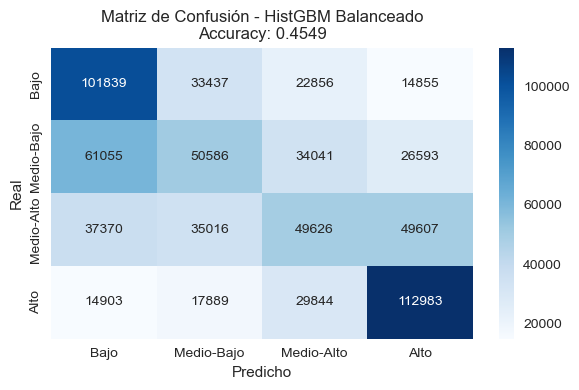

In [17]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'],
            yticklabels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])
plt.title(f'Matriz de Confusión - HistGBM Balanceado\nAccuracy: {train_accuracy:.4f}')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

el siguiente codigo proporciona métricas específicas por cada clase

In [18]:
print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y, y_pred, target_names=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto']))


REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        Bajo       0.47      0.59      0.52    172987
  Medio-Bajo       0.37      0.29      0.33    172275
  Medio-Alto       0.36      0.29      0.32    171619
        Alto       0.55      0.64      0.60    175619

    accuracy                           0.45    692500
   macro avg       0.44      0.45      0.44    692500
weighted avg       0.44      0.45      0.44    692500



Este código genera las predicciones finales para el dataset de test que se enviarán a Kaggle

In [19]:
print("\nGENERANDO PREDICCIONES FINALES...")
test_predictions = model.predict(test_processed)
print(f"Predicciones generadas: {len(test_predictions)}")


GENERANDO PREDICCIONES FINALES...
Predicciones generadas: 296786


Este código analiza y muestra la distribución de las predicciones generadas para el dataset de test

In [21]:
unique, counts = np.unique(test_predictions, return_counts=True)
print(f"\nDISTRIBUCIÓN DE PREDICCIONES:")
for val, count in zip(unique, counts):
    categoria = ['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'][val-1]
    porcentaje = (count / len(test_predictions)) * 100
    print(f"  {categoria}: {count} estudiantes ({porcentaje:.1f}%)")


DISTRIBUCIÓN DE PREDICCIONES:
  Bajo: 92772 estudiantes (31.3%)
  Medio-Bajo: 57467 estudiantes (19.4%)
  Medio-Alto: 59146 estudiantes (19.9%)
  Alto: 87401 estudiantes (29.4%)


crea el submission para enviar a kaggle

In [22]:
submission = pd.DataFrame({
    'ID': test_ids.values,
    'RENDIMIENTO_GLOBAL': test_predictions
})

convertir las predicciones numericas a texto

In [23]:
inverse_mapping = {1: 'bajo', 2: 'medio-bajo', 3: 'medio-alto', 4: 'alto'}
submission['RENDIMIENTO_GLOBAL'] = submission['RENDIMIENTO_GLOBAL'].map(inverse_mapping)

In [24]:
submission_file = 'submission_histgbm_balanceado.csv'
submission.to_csv(submission_file, index=False)

print(f"CV Accuracy del modelo: {score:.4f}")

CV Accuracy del modelo: 0.4318
